# Pectoral Muscle Removal from Mammograms

In [41]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab
from tqdm import tqdm
import os
from PIL import Image
from skimage import io, transform
from skimage.registration import phase_cross_correlation
from preprocess import read_image, otsu_cut, right_orient_mammogram, enhance_contrast, gaussian_blur, remove_text_label
from align_pectoral_line import *
from mammo_regist import ecc_score, register_scale_translation, pil_to_sitk, sitk_to_pil, sitk_rigid_registration
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Ensuring same orientation of all images
In order for the algorithm to generalize over all mammograms, we first right-orient all images. To detect left-oriented breast images, we simply compare the number of nonzero pixels on both half of the images.

This is quite a rudimentary way to detect orientation, and works because the the background pixels are completely black and thus gives us an idea of the location of breast on either half of the image

In [2]:
from glob import glob
image_list = glob("/mnt/f/EMBED_1080_ROI_JPG/EMBED_1080_ROI_JPG/images/*/*/*/*/*.jpg")
print(len(image_list))

98788


In [3]:
import pandas as pd
get_orig_path = lambda x: x.replace("/mnt/NAS2/mammo/anon_dicom", '/mnt/f/EMBED_1080_ROI_JPG/EMBED_1080_ROI_JPG/images').replace('.dcm', '_resized.jpg')
df = pd.read_csv("data/tables/EMBED_OpenData_metadata_reduced.csv")
df = df[df['FinalImageType'] == '2D']
screen_idx = df['StudyDescription'].apply(lambda x: x.lower().find('screen') > 0)
df = df[screen_idx]
df['new_path'] = df['anon_dicom_path'].apply(get_orig_path)
path_to_description = dict(zip(df['new_path'], df['SeriesDescription']))

/tmp/ipykernel_82750/3618476544.py:3: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/tables/EMBED_OpenData_metadata_reduced.csv")


In [4]:
mlo_images = [path for path in image_list if 'MLO' in path_to_description.get(path, '')]
print(len(mlo_images))

2157


In [3]:
from glob import glob
image_list = glob("/mnt/j/CSAW-CC-resized-1024/data/*.png")
image_set = set(image_list)
print(len(image_list))

mlo_images = [path for path in image_list if 'MLO' in path]
print(len(mlo_images))

paired_images = [(path, path.replace('MLO', 'CC')) for path in mlo_images if path.replace('MLO', 'CC') in image_set]
print(len(paired_images))

98788
49394
49394


### Image pre-processing

We first remove the text in the image by computing the area of each separate contour in the binarized image. We then use OTSU mask to cut the unnecessary background region and then rotate the image to the right orientation

/mnt/j/CSAW-CC-resized-1024/data/00020_20990909_R_CC_1_resized.png


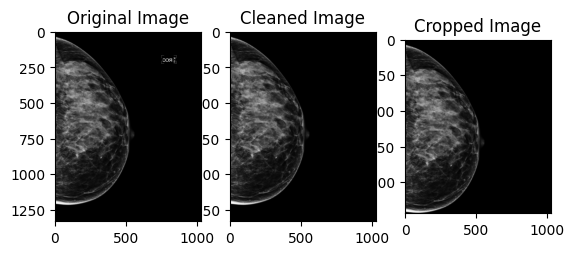

In [3]:
idx = 90
img = read_image(paired_images[idx][1])
print(paired_images[idx][1])
img = right_orient_mammogram(img)[0]
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
cleaned_img = remove_text_label(img)
plt.subplot(1, 3, 2)
plt.imshow(cleaned_img, cmap='gray')
plt.title('Cleaned Image')
img = otsu_cut(cleaned_img)
plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.title('Cropped Image')
plt.show()

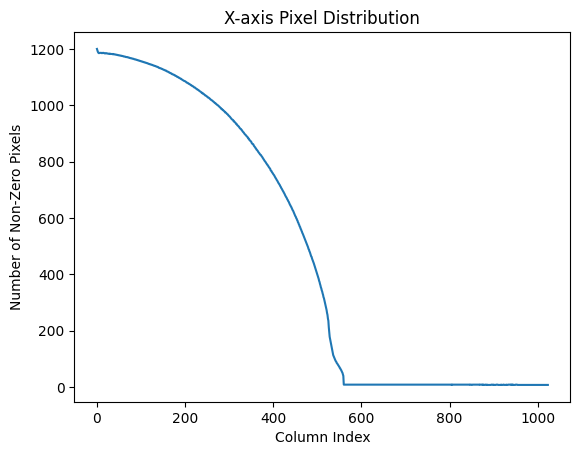

7
464 10.24


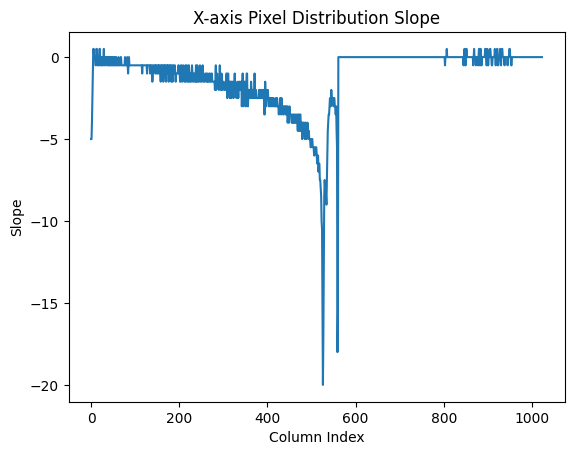

Breast right x-coordinate: 560


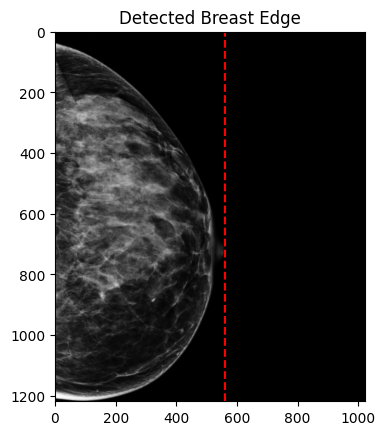

In [4]:
x_axis_dist = np.sum(np.array(img) > 0, axis=0)
plt.plot(x_axis_dist)
plt.title('X-axis Pixel Distribution')
plt.xlabel('Column Index')
plt.ylabel('Number of Non-Zero Pixels')
plt.show()
print(x_axis_dist.min())
print(np.sum(x_axis_dist < 10), 0.01 * x_axis_dist.shape[0])
x_axis_dist_slope = np.gradient(x_axis_dist)
plt.plot(x_axis_dist_slope)
plt.title('X-axis Pixel Distribution Slope')
plt.xlabel('Column Index')
plt.ylabel('Slope')
plt.show()
# Find the peak in the slope which indicates the edge of the breast
x_axis_dist_slope[x_axis_dist > np.max(x_axis_dist) * 0.1] = 0  # Ignore high intensity areas
breast_right_x_candidates = np.argsort(x_axis_dist_slope)[:5]  # Get top 5 peaks
breast_right_x = np.max(breast_right_x_candidates)
print("Breast right x-coordinate:", breast_right_x)
plt.imshow(img, cmap='gray')
plt.axvline(x=breast_right_x, color='r', linestyle='--')
plt.title('Detected Breast Edge')
plt.show()

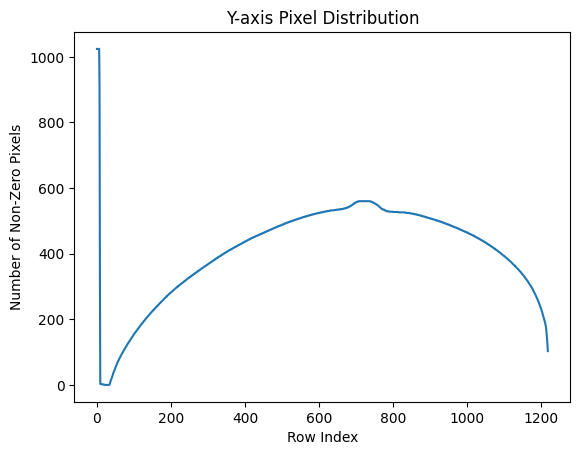

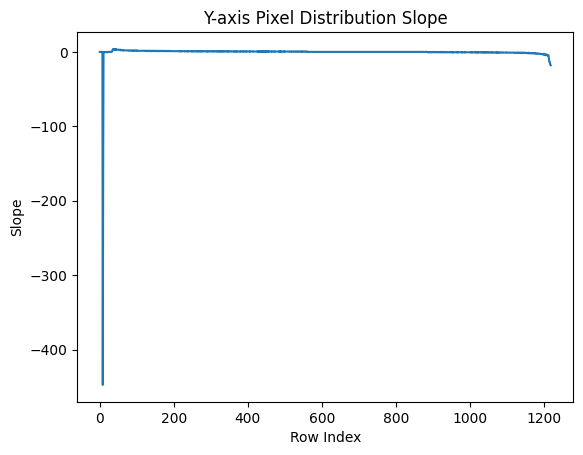

Breast bottom y-coordinate: 35


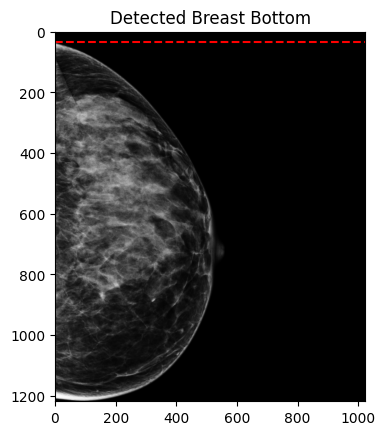

In [5]:
y_axis_dist = np.sum(np.array(img) > 0, axis=1)
plt.plot(y_axis_dist)
plt.title('Y-axis Pixel Distribution')
plt.xlabel('Row Index')
plt.ylabel('Number of Non-Zero Pixels')
plt.show()
y_axis_dist_slope = np.gradient(y_axis_dist)
y_axis_dist_slope[y_axis_dist > np.max(y_axis_dist) * 0.5] = 0  # Ignore high intensity areas
plt.plot(y_axis_dist_slope)
plt.title('Y-axis Pixel Distribution Slope')
plt.xlabel('Row Index')
plt.ylabel('Slope')
plt.show()

# Find the peak in the slope which indicates the top of the breast
breast_bottom_y_candidate = np.argsort(y_axis_dist_slope)[-5:]
breast_bottom_y = np.min(breast_bottom_y_candidate)
print("Breast bottom y-coordinate:", breast_bottom_y)
plt.imshow(img, cmap='gray')
plt.axhline(y=breast_bottom_y, color='r', linestyle='--')
plt.title('Detected Breast Bottom')
plt.show()

/mnt/j/CSAW-CC-resized-1024/data/00014_20990909_L_MLO_1_resized.png


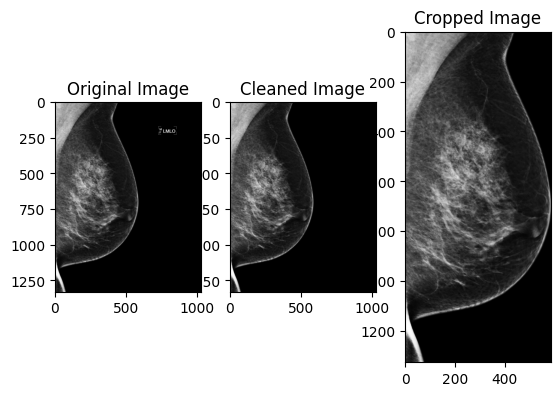

In [6]:
idx = 50
img = read_image(mlo_images[idx])
print(mlo_images[idx])
img = right_orient_mammogram(img)[0]
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
cleaned_img = remove_text_label(img)
plt.subplot(1, 3, 2)
plt.imshow(cleaned_img, cmap='gray')
plt.title('Cleaned Image')
img = otsu_cut(cleaned_img)
plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.title('Cropped Image')
plt.show()

### Enhance image contrast

Newer Mammography usually has better resolution and clearer than the old ones. We use histogram equalization to enhance the image contrast and highlight the pectoral region

### Applying canny edge detection

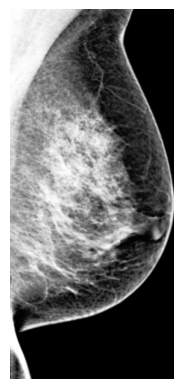

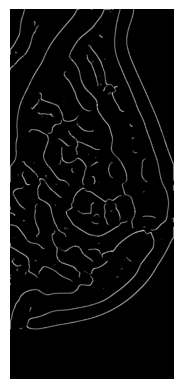

In [7]:
img = enhance_contrast(img)
img = gaussian_blur(img)
plt.figure()
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
canny_img = apply_canny(np.array(img), mask_bottom=True, mask_right=False)
plt.figure()
plt.imshow(canny_img, cmap='gray')
plt.axis('off')
plt.show()

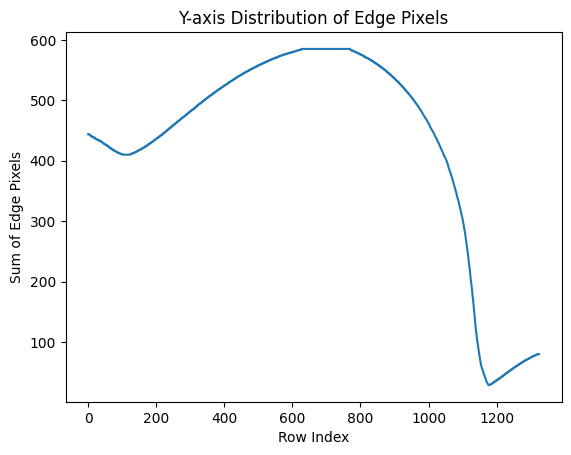

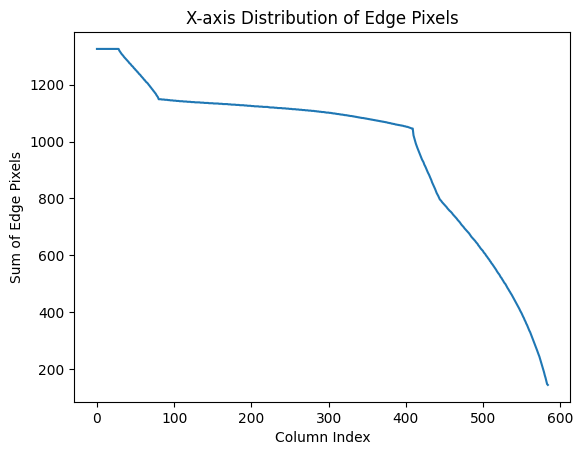

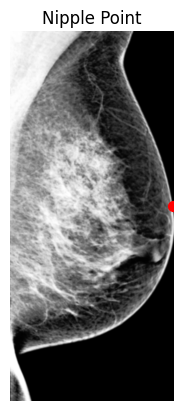

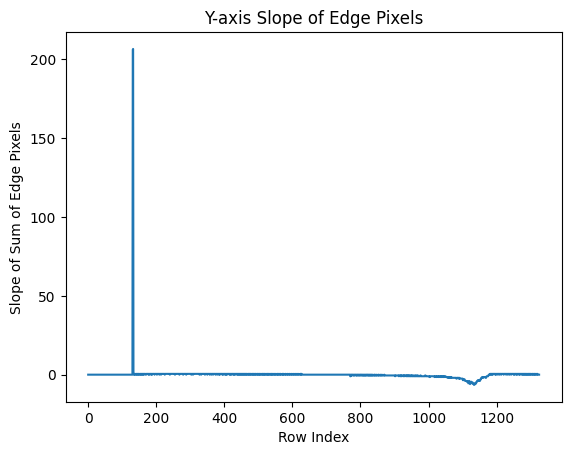

127 146.25


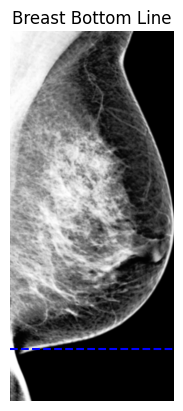

In [8]:
y_axis_dist = np.sum(np.array(img) > 0, axis=1)
x_axis_dist = np.sum(np.array(img) > 0, axis=0)
plt.figure()
plt.plot(y_axis_dist)
plt.title('Y-axis Distribution of Edge Pixels')
plt.xlabel('Row Index')
plt.ylabel('Sum of Edge Pixels')
plt.show()
plt.figure()
plt.plot(x_axis_dist)
plt.title('X-axis Distribution of Edge Pixels')
plt.xlabel('Column Index')
plt.ylabel('Sum of Edge Pixels')
plt.show()

# This is wrong since the breast is rotated in MLO view
y_axis_dist[:int(y_axis_dist.shape[0]*0.1)] = 0  # Ignore the top 10% of the image
nipple_y = np.argmax(y_axis_dist)
nipple_point = (np.array(img).shape[1] - 1, nipple_y)  # (x, y) format
# plot nipple point on the image
plt.figure()
plt.imshow(img, cmap='gray')
plt.scatter(nipple_point[0], nipple_point[1], c='r', s=50)
plt.title('Nipple Point')
plt.axis('off')
plt.show()

y_axis_dist_slope = np.gradient(y_axis_dist)
plt.figure()
plt.plot(y_axis_dist_slope)
plt.title('Y-axis Slope of Edge Pixels')
plt.xlabel('Row Index')
plt.ylabel('Slope of Sum of Edge Pixels')
plt.show()
# Find the breast bottom line as the row with the steepest negative slope and below the nipple
y_axis_dist_slope[:nipple_y] = 0  # Ignore slopes above the nipple
breast_bottom_y_candidate = np.argsort(y_axis_dist_slope)[:5]
breast_bottom_y = np.max(breast_bottom_y_candidate)
print(y_axis_dist[breast_bottom_y], 0.25 * np.array(img).shape[1])
if y_axis_dist[breast_bottom_y] > 0.25 * np.array(img).shape[1]:
    breast_bottom_y = np.array(img).shape[0]  # If not, set to the bottom of the image
# plot breast bottom line on the image
plt.figure()
plt.imshow(img, cmap='gray')
plt.axhline(y=breast_bottom_y, color='b', linestyle='--')
plt.title('Breast Bottom Line')
plt.axis('off')
plt.show()

### Applying Hough transform
Once we have obtained the edges using the Canny Edge Detector, we can apply Hough transform and make a list of output lines.

Each line is represented by an object with the following attributes
 - `dist`: perpendicular distance of the line from origin
 - `angle`: angle (in degrees) made by the perpendicular from the positive x-axis. This perpendicular is dropped on the line from the origin
 - `point1`, `point2`: two points on the line
 
Note: The x-axis and y-axis are oriented as shown in the image ouputs below.


All hough lines
Angle: -23.00, Dist: 328.00, Conf: 1.00
Angle: 28.00, Dist: 188.00, Conf: 0.75
Angle: -45.00, Dist: -354.00, Conf: 0.64
Angle: 17.00, Dist: 426.00, Conf: 0.61
Angle: 2.00, Dist: 39.00, Conf: 0.60
Angle: 79.00, Dist: 1143.00, Conf: 0.53
Angle: 45.00, Dist: 252.00, Conf: 0.53
Angle: -17.00, Dist: 215.00, Conf: 0.53
Angle: 18.00, Dist: 345.00, Conf: 0.50
Angle: 38.00, Dist: 192.00, Conf: 0.49
Angle: 31.00, Dist: 923.00, Conf: 0.49
Angle: -61.00, Dist: -745.00, Conf: 0.48
Angle: 29.00, Dist: 532.00, Conf: 0.48
Angle: 0.00, Dist: 582.00, Conf: 0.47
Angle: -8.00, Dist: 46.00, Conf: 0.47
Angle: 2.00, Dist: 378.00, Conf: 0.46
Angle: -24.00, Dist: 16.00, Conf: 0.46
Angle: 12.00, Dist: 236.00, Conf: 0.46
Angle: -23.00, Dist: 150.00, Conf: 0.46
Angle: -6.00, Dist: 311.00, Conf: 0.46
Angle: 45.00, Dist: 870.00, Conf: 0.45
Angle: -23.00, Dist: 96.00, Conf: 0.45
Angle: 45.00, Dist: 989.00, Conf: 0.45
Angle: -32.00, Dist: 40.00, Conf: 0.44
Angle: -45.00, Dist: 28.00, Conf: 0.44
Angle

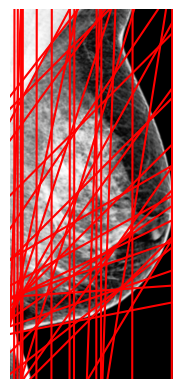

In [9]:
# plot the hough lines on the image
lines = get_hough_lines(canny_img, verbose=True)
plt.figure()
plt.imshow(img, cmap='gray')
plt.xlim(0,np.array(img).shape[1])
plt.ylim(np.array(img).shape[0])
for line in lines:
    plt.plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
plt.axis('off')
plt.show()


Shorlisted lines
Angle: 12.00, Dist: 236.00, Conf: 0.46
Angle: 17.00, Dist: 426.00, Conf: 0.61
Angle: 18.00, Dist: 345.00, Conf: 0.50
Angle: 28.00, Dist: 188.00, Conf: 0.75
Angle: 34.00, Dist: 440.00, Conf: 0.32
Angle: 36.00, Dist: 276.00, Conf: 0.41
Angle: 38.00, Dist: 192.00, Conf: 0.49
Angle: 45.00, Dist: 252.00, Conf: 0.53


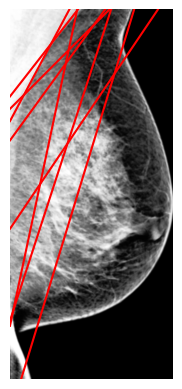

In [10]:
# plot the hough lines on the image
lines = shortlist_lines(lines, canny_img.shape[1], True)
plt.figure()
plt.imshow(img, cmap='gray')
plt.xlim(0,np.array(img).shape[1])
plt.ylim(np.array(img).shape[0])
for line in lines:
    plt.plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
plt.axis('off')
plt.show()

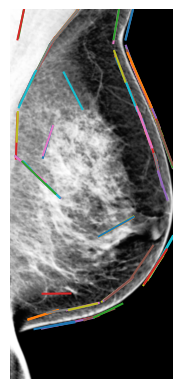

In [11]:
from skimage.transform import probabilistic_hough_line

lines = probabilistic_hough_line(canny_img, threshold=10, line_length=100, line_gap=20)
plt.figure()
plt.imshow(img, cmap='gray')
plt.xlim(0,np.array(img).shape[1])
plt.ylim(np.array(img).shape[0])
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.axis('off')
plt.show()

### Shortlisting lines
We need to shortlist possible candidates for pectoral segmentation. A simple criteria for shortlisting can be simply checking whether the `angle` and `dist` values of each line lies inside a particular interval.

The intervals are `MIN_ANGLE <= angle <= MAX_ANGLE` and `MIN_DIST <= dist <= MAX_DIST`.

These 4 parameters can be easily learned given a bigger dataset of mammograms. However, for now these have been picked manually using judgement on the given 5 images, and seem to work well.

#### TODO: consider make the dist threshold to be adaptive wrt. to the image size

### Removing pectoral region
If more than one line is shortlisted, we select the one which will cause the least loss of information (the safest approach).

For this, we sort these lines by their distance from origin `dist` and pick the nearest line. Then we simply set the value to zero of those pixels enclosed within a polygon formed by the picked line and the border of the image.

### Pick the correct line that segment the pectoral region

Consider the situation with more than one lines in the shortlist, we want the pick the line that keep as much breast region as possible while correctly separate the pectoral region.

we note that the pectoral region usually has a different contrast than the breast region (due to its tissue composition), so we compute the STD of the ROI for each line in the shortlist and pick the one with smallest STD, namely, most tissue in the region is identical.

### Displaying final result
The result for all the five images is displayed below. We can easily compare the removed pectoral area with the original image.

#### TODO: rotate the image back to the correct orientation after all processing


All hough lines
Angle: -90.00, Dist: -2.00, Conf: 1.00
Angle: 1.00, Dist: 457.00, Conf: 0.39
Angle: -17.00, Dist: 344.00, Conf: 0.38
Angle: 31.00, Dist: 440.00, Conf: 0.37
Angle: 0.00, Dist: 2.00, Conf: 0.36
Angle: 30.00, Dist: 195.00, Conf: 0.33
Angle: 3.00, Dist: 509.00, Conf: 0.32

Shorlisted lines
Angle: 30.00, Dist: 195.00, Conf: 0.33
Angle: 31.00, Dist: 440.00, Conf: 0.37


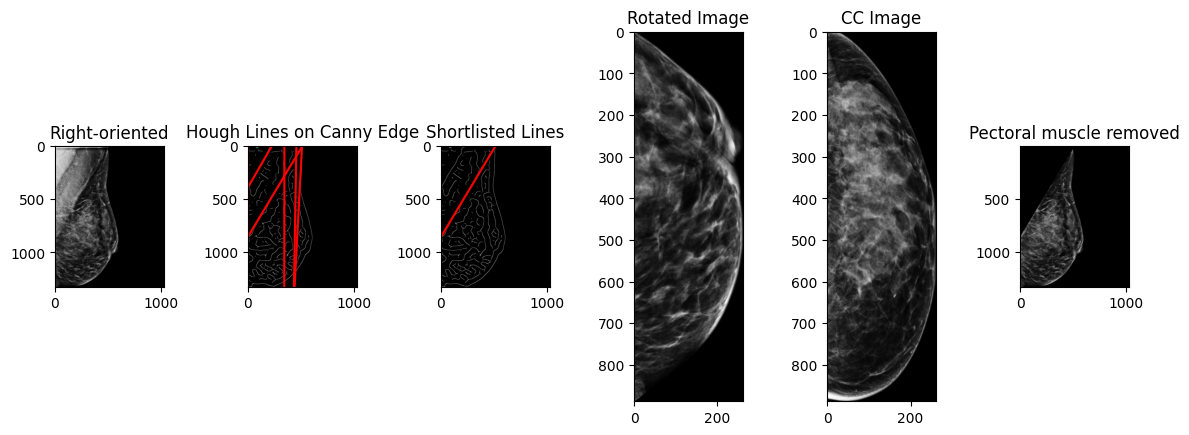

(<PIL.Image.Image image mode=L size=261x888>,
 array([[162, 164, 167, ...,   0,   0,   0],
        [144, 149, 158, ...,   0,   0,   0],
        [121, 124, 132, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8))

In [12]:
display_image(paired_images[90], verbose=True, dest=None, show_img=True, filled_align=True)

In [4]:
std_list.clear()
angle_list.clear()
# save_dir = "tmp/filled_align_hough_conf_top_bottom_right_cut/"
# os.makedirs(save_dir, exist_ok=True)
save_dir = None
pair_aligned = []
for i in tqdm(range(0, 1000)):
    aligned_image_pair = display_image(paired_images[i], verbose=False, dest=save_dir, show_img=False, filled_align=True)
    pair_aligned.append(aligned_image_pair)

100%|██████████| 1000/1000 [04:16<00:00,  3.91it/s]


In [78]:
std_list.clear()
angle_list.clear()
save_dir = "tmp/filled_align_hough_conf_top_bottom_right_cut/"
os.makedirs(save_dir, exist_ok=True)
# save_dir = None
pair_aligned = []
for i in tqdm(range(0, 1000)):
    aligned_image_pair = display_image(paired_images[i], verbose=False, dest=save_dir, show_img=False, filled_align=True)
    pair_aligned.append(aligned_image_pair)

100%|██████████| 1000/1000 [05:38<00:00,  2.96it/s]


In [14]:
from glob import glob
pair_aligned = []
local_images = glob("tmp/filled_align_hough_conf_top_bottom_right_cut/*_aligned.png")
for im_path in local_images:
    if 'CC' in im_path:
        continue
    cc_path = im_path.replace('MLO', 'CC').replace('\\', '/')
    mlo_image = Image.open(im_path).convert('L')
    cc_image = Image.open(cc_path).convert('L')
    aligned_image_pair = (mlo_image, cc_image)
    pair_aligned.append(aligned_image_pair) 

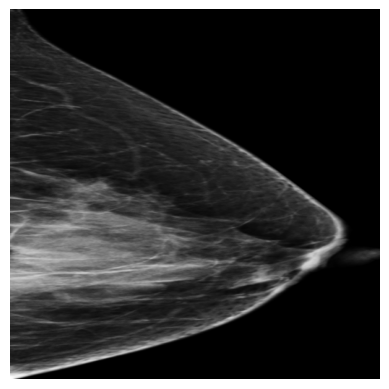

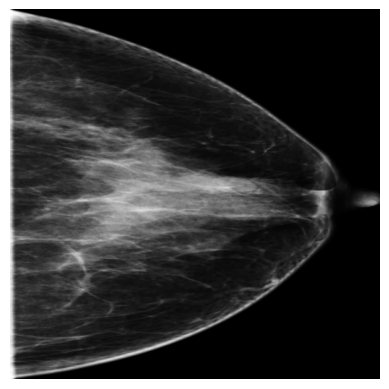

In [16]:
plt.imshow(pair_aligned[0][0].resize((512, 512)), cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(pair_aligned[0][1].resize((512, 512)), cmap='gray')
plt.axis('off')
plt.show()

# Phase correlation (only for translation)

In [ ]:

correlated_image_pairs = []
for i in tqdm(range(len(pair_aligned))):

    cc_image = np.array(pair_aligned[i][1].resize((512, 512)))
    mlo_image = np.array(pair_aligned[i][0].resize((512, 512)))

    try:
        shift, error, phasediff = phase_cross_correlation(cc_image > 0, mlo_image > 0, upsample_factor=100)
        tform = transform.SimilarityTransform(translation=(-shift[1], -shift[0]))
        aligned = transform.warp(mlo_image, tform)
    except Exception as e:
        print(f"Error processing image pair {i}: {e}")
        aligned = mlo_image  # Fallback to original if error occurs

    correlated_image_pairs.append((aligned, cc_image))

    # plt.figure(figsize=(12,6))

    # plt.subplot(1,3,1)
    # plt.title('Original CC Image')
    # plt.imshow(cc_image, cmap='gray')
    # plt.axis('off')
    # plt.subplot(1,3,2)
    # plt.title('Original MLO Image')
    # plt.imshow(mlo_image, cmap='gray')
    # plt.axis('off')
    # plt.subplot(1,3,3)
    # plt.title('Aligned MLO Image')
    # plt.imshow(aligned, cmap='gray')
    # plt.axis('off')
    # plt.show()

100%|██████████| 990/990 [00:40<00:00, 24.34it/s]


# Full Affine registration

In [17]:
import cv2

affined_pair = []

for i in tqdm(range(len(pair_aligned))):

    mlo_image = np.array(pair_aligned[i][0].resize((512, 512))).astype(np.float32)
    cc_image = np.array(pair_aligned[i][1].resize((512, 512))).astype(np.float32)
    try:
        warp_mode = cv2.MOTION_AFFINE   # or MOTION_TRANSLATION / MOTION_AFFINE
        warp = np.eye(2, 3, dtype=np.float32)  # 2x3 for Euclidean/similarity/affine

        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 200, 1e-6)
        (cc, warp) = cv2.findTransformECC(cc_image, mlo_image, warp, warp_mode, criteria)

        aligned = cv2.warpAffine(mlo_image, warp, (cc_image.shape[1], cc_image.shape[0]),
                                flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        affined_pair.append((aligned, cc_image))
    except Exception as e:
        print(f"Error processing image pair {i}: {e}")
        affined_pair.append((mlo_image, cc_image))  # Append original if error occurs

# plt.figure(figsize=(12,6))

# plt.subplot(1,3,1)
# plt.title('Original CC Image')
# plt.imshow(cc_image, cmap='gray')
# plt.axis('off')
# plt.subplot(1,3,2)
# plt.title('Original MLO Image')
# plt.imshow(mlo_image, cmap='gray')
# plt.axis('off')
# plt.subplot(1,3,3)
# plt.title('Aligned MLO Image')
# plt.imshow(aligned, cmap='gray')
# plt.axis('off')
# plt.show()

  1%|          | 8/990 [00:04<08:09,  2.01it/s]

Error processing image pair 8: OpenCV(4.11.0) /io/opencv/modules/video/src/ecc.cpp:589: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'findTransformECC'



 34%|███▍      | 335/990 [03:07<05:09,  2.11it/s]

Error processing image pair 335: OpenCV(4.11.0) /io/opencv/modules/video/src/ecc.cpp:589: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'findTransformECC'



 41%|████      | 404/990 [03:48<05:54,  1.65it/s]

Error processing image pair 404: OpenCV(4.11.0) /io/opencv/modules/video/src/ecc.cpp:589: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'findTransformECC'



 75%|███████▌  | 746/990 [06:57<02:05,  1.95it/s]

Error processing image pair 746: OpenCV(4.11.0) /io/opencv/modules/video/src/ecc.cpp:589: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'findTransformECC'



 79%|███████▉  | 784/990 [07:16<02:06,  1.63it/s]

Error processing image pair 784: OpenCV(4.11.0) /io/opencv/modules/video/src/ecc.cpp:589: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'findTransformECC'



 82%|████████▏ | 810/990 [07:31<01:47,  1.67it/s]

Error processing image pair 810: OpenCV(4.11.0) /io/opencv/modules/video/src/ecc.cpp:589: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'findTransformECC'



100%|██████████| 990/990 [09:14<00:00,  1.78it/s]


# Rotation + Translation

In [23]:
import cv2

motion_pair = []

for i in tqdm(range(len(pair_aligned))):

    mlo_image = np.array(pair_aligned[i][0].resize((512, 512))).astype(np.float32)
    cc_image = np.array(pair_aligned[i][1].resize((512, 512))).astype(np.float32)
    try:
        warp_mode = cv2.MOTION_EUCLIDEAN   # or MOTION_TRANSLATION / MOTION_AFFINE
        warp = np.eye(2, 3, dtype=np.float32)  # 2x3 for Euclidean/similarity/affine

        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 200, 1e-6)
        (cc, warp) = cv2.findTransformECC(cc_image, mlo_image, warp, warp_mode, criteria)

        aligned = cv2.warpAffine(mlo_image, warp, (cc_image.shape[1], cc_image.shape[0]),
                                flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        motion_pair.append((aligned, cc_image))
    except Exception as e:
        print(f"Error processing image pair {i}: {e}")
        motion_pair.append((mlo_image, cc_image))  # Append original if error occurs

    # plt.figure(figsize=(12,6))

    # plt.subplot(1,3,1)
    # plt.title('Original CC Image')
    # plt.imshow(cc_image, cmap='gray')
    # plt.axis('off')
    # plt.subplot(1,3,2)
    # plt.title('Original MLO Image')
    # plt.imshow(mlo_image, cmap='gray')
    # plt.axis('off')
    # plt.subplot(1,3,3)
    # plt.title('Aligned MLO Image')
    # plt.imshow(aligned, cmap='gray')
    # plt.axis('off')
    # plt.show()

 34%|███▍      | 335/990 [01:41<03:49,  2.85it/s]

Error processing image pair 335: OpenCV(4.11.0) /io/opencv/modules/video/src/ecc.cpp:589: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'findTransformECC'



 41%|████      | 404/990 [02:05<04:16,  2.28it/s]

Error processing image pair 404: OpenCV(4.11.0) /io/opencv/modules/video/src/ecc.cpp:589: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'findTransformECC'



100%|██████████| 990/990 [05:08<00:00,  3.21it/s]


# SimpleITK registration

In [40]:
sitk_registered_pair = []
for i in tqdm(range(len(pair_aligned))):
    mlo_image, cc_img = pair_aligned[i]
    mlo_image = mlo_image.resize((512, 512))
    cc_img = cc_img.resize((512, 512))
    try:
        registered_img = sitk_rigid_registration(cc_img, mlo_image)
    except Exception as e:
        registered_img = mlo_image
        print(f"Registration failed for pair {i}: {e}")
    
    # plt.figure(figsize=(12,6))

    # plt.subplot(1,3,1)
    # plt.title('Original CC Image')
    # plt.imshow(cc_image, cmap='gray')
    # plt.axis('off')
    # plt.subplot(1,3,2)
    # plt.title('Original MLO Image')
    # plt.imshow(mlo_image, cmap='gray')
    # plt.axis('off')
    # plt.subplot(1,3,3)
    # plt.title('Aligned MLO Image')
    # plt.imshow(aligned, cmap='gray')
    # plt.axis('off')
    # plt.show()
    
    # break
    sitk_registered_pair.append((np.array(registered_img), np.array(cc_img)))

100%|██████████| 990/990 [15:22<00:00,  1.07it/s]


100%|██████████| 1000/1000 [00:04<00:00, 211.08it/s]


EMD: mean 0.12, std 0.07, min 0.02, max 0.41
KLD: mean 3.72, std 1.79, min 0.61, max 17.02
MI: mean 4.34, std 0.46, min 2.35, max 5.47
Overlap: mean 0.78, std 0.11, min 0.25, max 0.95


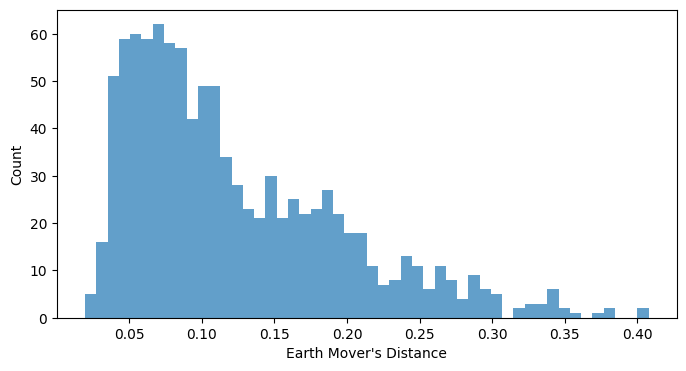

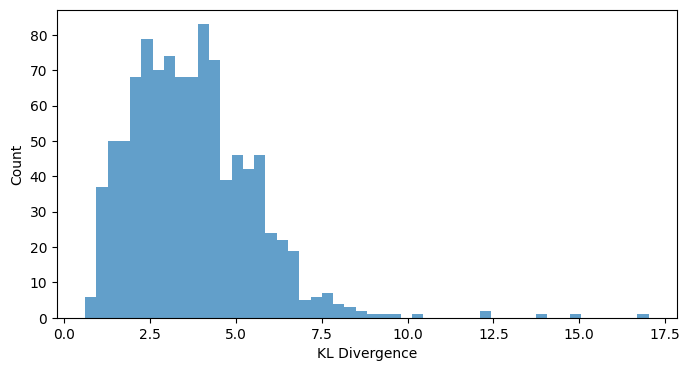

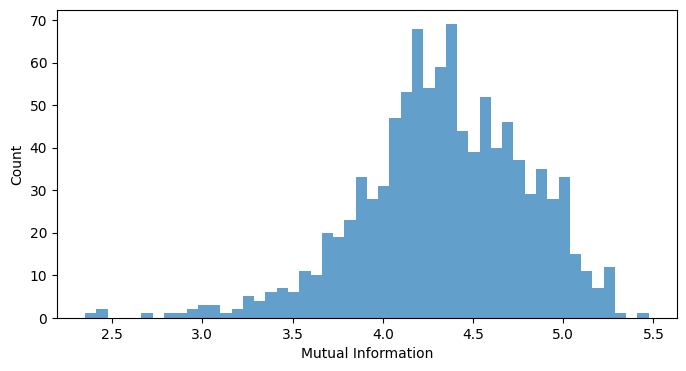

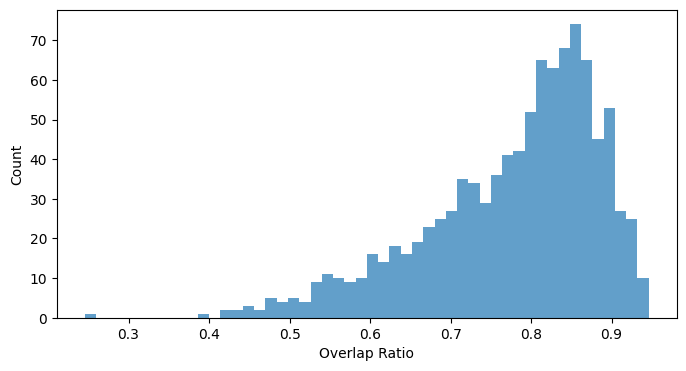

In [54]:
os.makedirs("tmp/ap_dist/", exist_ok=True)
res_emd = []
res_kld = []
res_mi = []
res_overlap = []
for i in tqdm(range(len(pair_aligned))):
    mlo_image = pair_aligned[i][0].resize((512, 512))
    cc_image = pair_aligned[i][1].resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=False)
    # res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=f"tmp/ap_dist/pair_{i}.png")
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])
    res_overlap.append(res_dict['overlap'])

print("EMD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_emd), np.std(res_emd), np.min(res_emd), np.max(res_emd)))
print("KLD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_kld), np.std(res_kld), np.min(res_kld), np.max(res_kld)))
print("MI: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_mi), np.std(res_mi), np.min(res_mi), np.max(res_mi)))
print("Overlap: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_overlap), np.std(res_overlap), np.min(res_overlap), np.max(res_overlap)))
plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")
plot_1d_histogram(res_overlap, bins=50, xlabel="Overlap Ratio", ylabel="Count")

# Scratch and Crop

  0%|          | 0/1 [00:00<?, ?it/s]

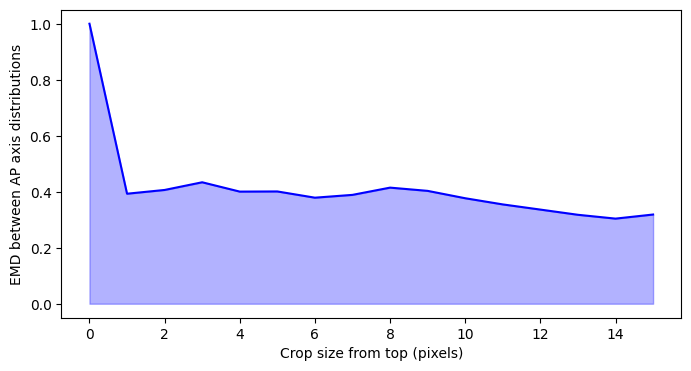

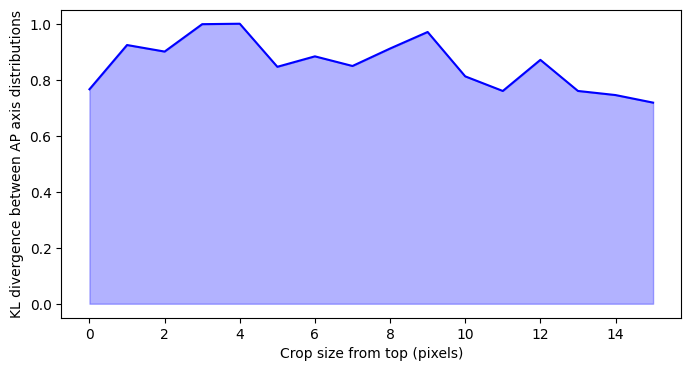

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

best crop 112 0.05461204110101988


In [51]:
# try shifting the mlo image up to find the optimal alignment
for i in tqdm(range(1)):
    mlo_image, cc_image = pair_aligned[i]
    # print(mlo_image.size, cc_image.size)
    mlo_image = mlo_image.copy().resize((512, 512))
    cc_image = cc_image.copy().resize((512, 512))
    emd_list = []
    kld_list = []
    for crop in range(0, 128, 8):
        # print("Crop size from top:", crop)
        # mlo_image_cropped = Image.fromarray(np.array(mlo_image)[:, crop:]).resize((512, 512))
        # res = display_distribution_res(mlo_image_cropped, cc_image, smooth_sigma=5, show_img=True)
        cc_image_cropped = Image.fromarray(np.array(cc_image)[:, crop:]).resize((512, 512))
        res = display_distribution_res(mlo_image, cc_image_cropped, smooth_sigma=5, show_img=False)
        emd_list.append(res['emd'])
        kld_list.append(res['kld'])

    plot_1d_distribution(emd_list, xlabel='Crop size from top (pixels)', ylabel='EMD between AP axis distributions')
    plot_1d_distribution(kld_list, xlabel='Crop size from top (pixels)', ylabel='KL divergence between AP axis distributions')
    print("best crop", np.argmin(emd_list) * 8, np.min(emd_list))

In [52]:
# try shifting the mlo image up to find the optimal alignment
shifted_paired_image = []
for i in tqdm(range(len(pair_aligned))):
    mlo_image, cc_image = pair_aligned[i]
    # print(mlo_image.size, cc_image.size)
    mlo_image = mlo_image.copy().resize((512, 512))
    cc_image = cc_image.copy().resize((512, 512))
    min_emd = np.inf
    optimal_cc_image = None
    emd_list = []
    for crop in range(0, 128, 8):
        # print("Crop size from top:", crop)
        # mlo_image_cropped = Image.fromarray(np.array(mlo_image)[:, crop:]).resize((512, 512))
        # res = display_distribution_res(mlo_image_cropped, cc_image, smooth_sigma=5, show_img=False)
        cc_image_cropped = Image.fromarray(np.array(cc_image)[:, crop:]).resize((512, 512))
        res = display_distribution_res(mlo_image, cc_image_cropped, smooth_sigma=5, show_img=False)
        emd_list.append(res['emd'])
        if res['emd'] < min_emd:
            min_emd = res['emd']
            optimal_cc_image = cc_image_cropped
    shifted_paired_image.append((mlo_image, optimal_cc_image))

    # plot_1d_distribution(emd_list, xlabel='Crop size from top (pixels)', ylabel='EMD between AP axis distributions')
    # print("best crop", np.argmin(emd_list) * 16, np.min(emd_list))

100%|██████████| 1000/1000 [00:33<00:00, 29.93it/s]


## Scale & Rotation & Crop
$O(n^2)$ search space

In [53]:
# try shifting the mlo image up to find the optimal alignment
shifted_rotated_paired_image = []
for i in tqdm(range(len(pair_aligned))):
# for i in tqdm(range(len(pair_aligned))):
    mlo_image, cc_image = pair_aligned[i]
    # print(mlo_image.size, cc_image.size)
    mlo_image = mlo_image.copy().resize((512, 512))
    cc_image = cc_image.copy().resize((512, 512))
    min_emd = np.inf
    best_crop = None
    best_rot = None
    optimal_cc_image = None
    optimal_mlo_image = None
    emd_list = []
    kld_list = []
    crop_list = list(range(0, 128, 8))
    rot_list = list(range(-10, 11, 2))
    for crop in crop_list:
        for rot in rot_list:
            # mlo_image_cropped = Image.fromarray(np.array(mlo_image)[:, crop:]).resize((512, 512))
            # res = display_distribution_res(mlo_image_cropped, cc_image, smooth_sigma=5, show_img=False)
            # rotate mlo image by rot degrees
            # mlo_image_rotated = mlo_image.rotate(rot, resample=Image.BILINEAR, expand=False)
            if rot > 0:
                # rotate anticlockwise, choose left bottom corner as anchor
                # use cv2 to rotate around anchor
                M = cv2.getRotationMatrix2D((0, mlo_image.size[1]), rot, 1.0)
                expanded_image = np.zeros((mlo_image.size[1] * 2, mlo_image.size[0] * 2))
                # place the original image at the bottom left corner
                expanded_image[mlo_image.size[1]:, :mlo_image.size[0]] = np.array(mlo_image)
                mlo_image_rotated = Image.fromarray(cv2.warpAffine(np.array(mlo_image), M, (expanded_image.shape[1], expanded_image.shape[0])))
            else:
                # rotate anticlockwise, choose top left corner as anchor
                M = cv2.getRotationMatrix2D((0, 0), rot, 1.0)
                expanded_image = np.zeros((mlo_image.size[1] * 2, mlo_image.size[0] * 2))
                # place the original image at the top left corner
                expanded_image[:mlo_image.size[1], :mlo_image.size[0]] = np.array(mlo_image)
                mlo_image_rotated = Image.fromarray(cv2.warpAffine(np.array(mlo_image), M, (expanded_image.shape[1], expanded_image.shape[0])))
            
            # crop cc image by crop pixels from left
            cc_image_cropped = Image.fromarray(np.array(cc_image)[:, crop:]).resize((512, 512))
            # post process both images with adaptive cut top and right black areas
            
            mlo_image_rotated = adaptive_cut_right_fn(adaptive_cut_bottom_fn(adaptive_cut_top_fn(np.array(mlo_image_rotated))[0])[0])[0]
            mlo_image_rotated = Image.fromarray(mlo_image_rotated).resize((512, 512))
            cc_image_cropped = adaptive_cut_right_fn(adaptive_cut_top_fn(np.array(cc_image_cropped))[0])[0]
            cc_image_cropped = Image.fromarray(cc_image_cropped).resize((512, 512))
            
            res = display_distribution_res(mlo_image_rotated, cc_image_cropped, smooth_sigma=5, show_img=False)
            emd_list.append(res['emd'])
            kld_list.append(res['kld'])
            if res['emd'] < min_emd:
                min_emd = res['emd']
                best_crop = crop
                best_rot = rot
                optimal_mlo_image = mlo_image_rotated.copy()
                optimal_cc_image = cc_image_cropped.copy()
    shifted_rotated_paired_image.append((optimal_mlo_image, optimal_cc_image))

    # plot_2d_distribution(np.array(emd_list).reshape(-1, len(rot_list)), xlabel='Rotation (degrees)', ylabel='Crop size from top (pixels)', x_tick=rot_list)
    # plot_2d_distribution(np.array(kld_list).reshape(-1, len(rot_list)), xlabel='Rotation (degrees)', ylabel='Crop size from top (pixels)', x_tick=rot_list)
    # print("best crop", best_crop)
    # print("best rotation", best_rot)
    # res_orig = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, show_img=True)
    # res_final = display_distribution_res(optimal_mlo_image, optimal_cc_image, smooth_sigma=5, show_img=True)

100%|██████████| 1000/1000 [20:23<00:00,  1.22s/it]


100%|██████████| 1000/1000 [02:54<00:00,  5.74it/s]


EMD: mean 0.06, std 0.04, min 0.01, max 0.35
KLD: mean 3.51, std 1.89, min 0.55, max 17.02
MI: mean 4.46, std 0.45, min 2.35, max 5.67
Overlap: mean 0.89, std 0.07, min 0.25, max 0.97


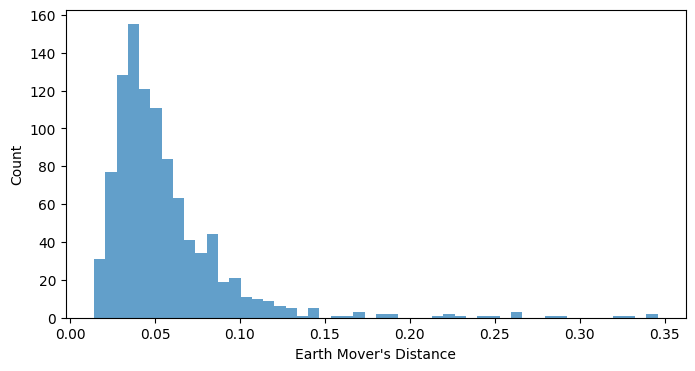

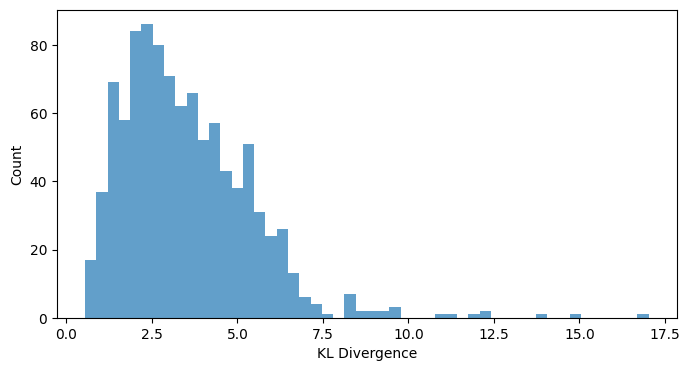

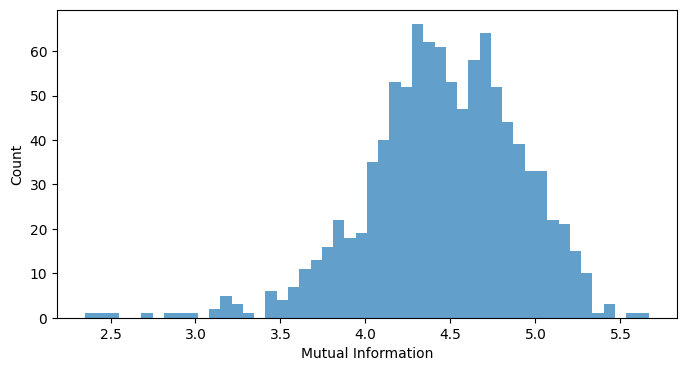

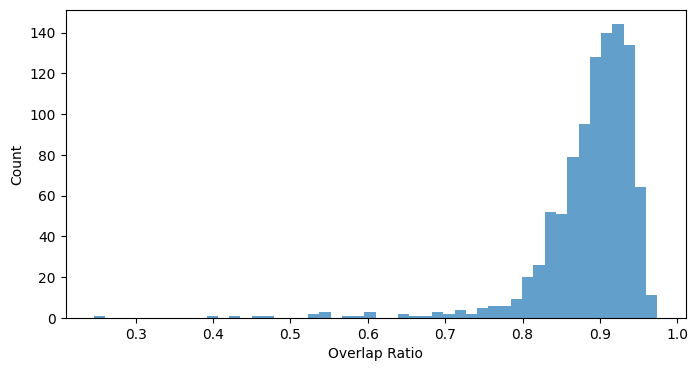

In [55]:
os.makedirs("tmp/ap_dist_shifted/", exist_ok=True)
res_emd = []
res_kld = []
res_mi = []
res_overlap = []
for i in tqdm(range(len(shifted_paired_image))):
    mlo_image = shifted_paired_image[i][0].resize((512, 512))
    cc_image = shifted_paired_image[i][1].resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    # res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=False)
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=f"tmp/ap_dist_shifted/pair_{i}.png")
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])
    res_overlap.append(res_dict['overlap'])

print("EMD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_emd), np.std(res_emd), np.min(res_emd), np.max(res_emd)))
print("KLD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_kld), np.std(res_kld), np.min(res_kld), np.max(res_kld)))
print("MI: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_mi), np.std(res_mi), np.min(res_mi), np.max(res_mi)))
print("Overlap: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_overlap), np.std(res_overlap), np.min(res_overlap), np.max(res_overlap)))
plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")
plot_1d_histogram(res_overlap, bins=50, xlabel="Overlap Ratio", ylabel="Count")

100%|██████████| 1000/1000 [02:52<00:00,  5.79it/s]


EMD: mean 0.05, std 0.02, min 0.01, max 0.18
KLD: mean 3.50, std 1.74, min 0.45, max 12.15
MI: mean 4.49, std 0.41, min 2.94, max 5.67
Overlap: mean 0.90, std 0.04, min 0.65, max 0.97


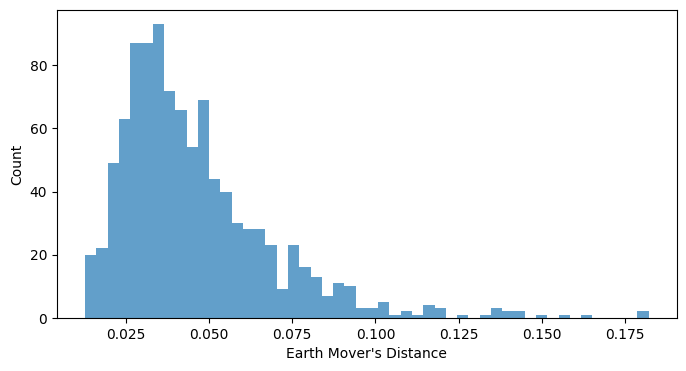

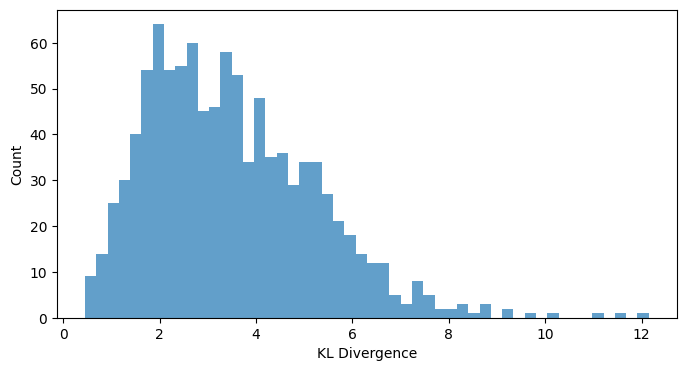

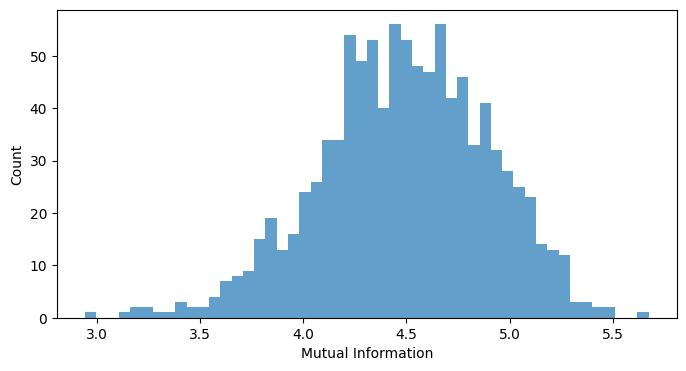

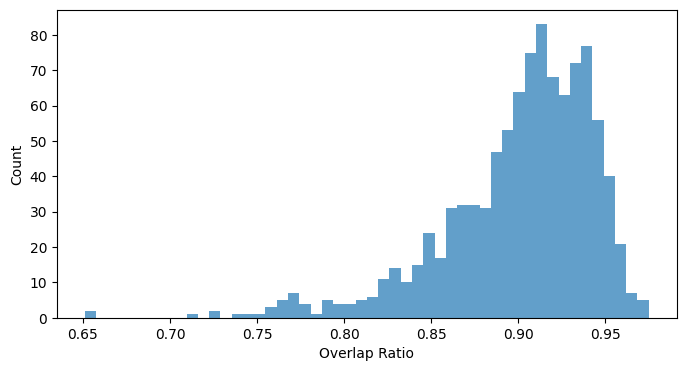

In [56]:
os.makedirs("tmp/ap_dist_shifted_rotated/", exist_ok=True)
res_emd = []
res_kld = []
res_mi = []
res_overlap = []
for i in tqdm(range(len(shifted_rotated_paired_image))):
    mlo_image = shifted_rotated_paired_image[i][0].resize((512, 512))
    cc_image = shifted_rotated_paired_image[i][1].resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    # res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=False)
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=f"tmp/ap_dist_shifted_rotated/pair_{i}.png")
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])
    res_overlap.append(res_dict['overlap'])

print("EMD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_emd), np.std(res_emd), np.min(res_emd), np.max(res_emd)))
print("KLD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_kld), np.std(res_kld), np.min(res_kld), np.max(res_kld)))
print("MI: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_mi), np.std(res_mi), np.min(res_mi), np.max(res_mi)))
print("Overlap: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_overlap), np.std(res_overlap), np.min(res_overlap), np.max(res_overlap)))
plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")
plot_1d_histogram(res_overlap, bins=50, xlabel="Overlap Ratio", ylabel="Count")

100%|██████████| 1000/1000 [00:00<00:00, 1285.20it/s]


EMD: mean 0.12, std 0.06, min 0.02, max 0.48
KLD: mean 4.08, std 1.95, min 0.83, max 15.98
MI: mean 4.39, std 0.37, min 1.89, max 5.40
Overlap: mean 0.79, std 0.09, min 0.19, max 0.95


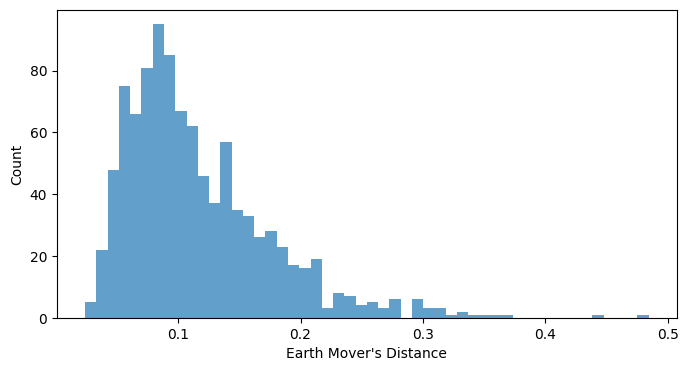

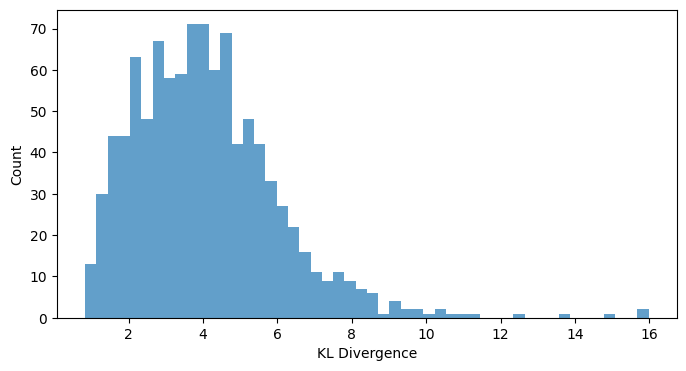

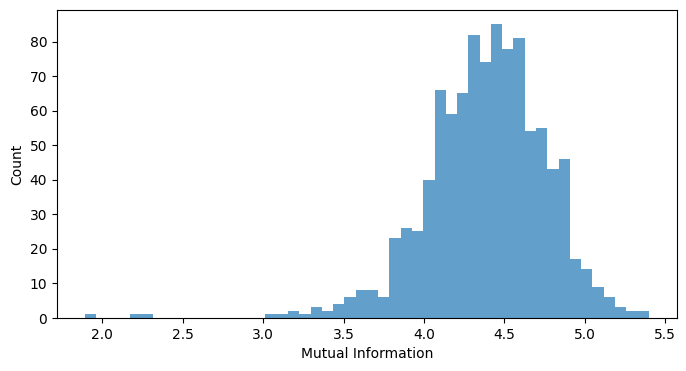

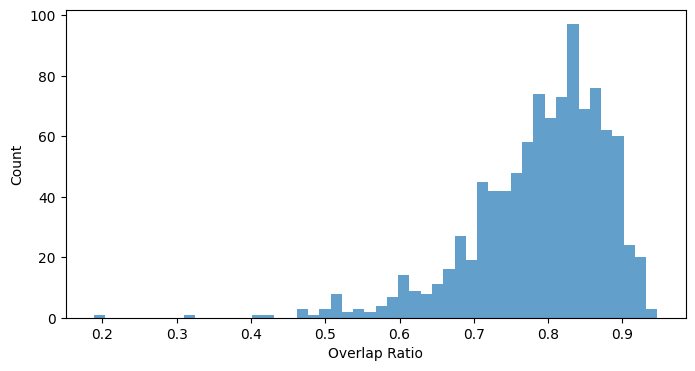

In [57]:
import random
random.seed(42)
shuffled_indices = list(range(1000))
random.shuffle(shuffled_indices)
res_emd = []
res_kld = []
res_mi = []
res_overlap = []
for i in tqdm(range(1000)):
    mlo_image = shifted_paired_image[i][0].resize((512, 512))
    cc_image = shifted_paired_image[shuffled_indices[i]][1].resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=False)
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])
    res_overlap.append(res_dict['overlap'])

print("EMD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_emd), np.std(res_emd), np.min(res_emd), np.max(res_emd)))
print("KLD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_kld), np.std(res_kld), np.min(res_kld), np.max(res_kld)))
print("MI: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_mi), np.std(res_mi), np.min(res_mi), np.max(res_mi)))
print("Overlap: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_overlap), np.std(res_overlap), np.min(res_overlap), np.max(res_overlap)))
plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")
plot_1d_histogram(res_overlap, bins=50, xlabel="Overlap Ratio", ylabel="Count")

100%|██████████| 1000/1000 [00:00<00:00, 1236.51it/s]


EMD: mean 0.11, std 0.05, min 0.02, max 0.32
KLD: mean 4.10, std 1.92, min 0.55, max 17.10
MI: mean 4.42, std 0.32, min 3.36, max 5.44
Overlap: mean 0.80, std 0.08, min 0.46, max 0.96


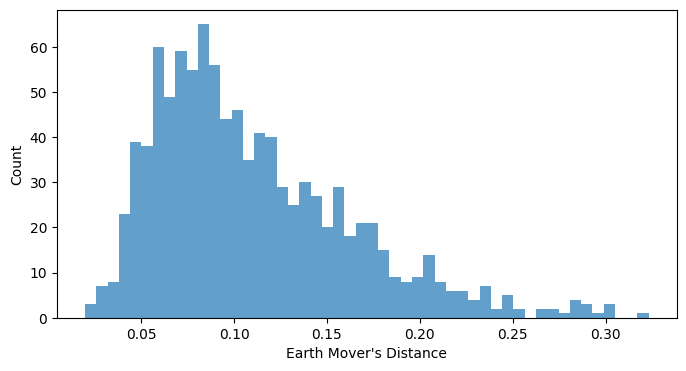

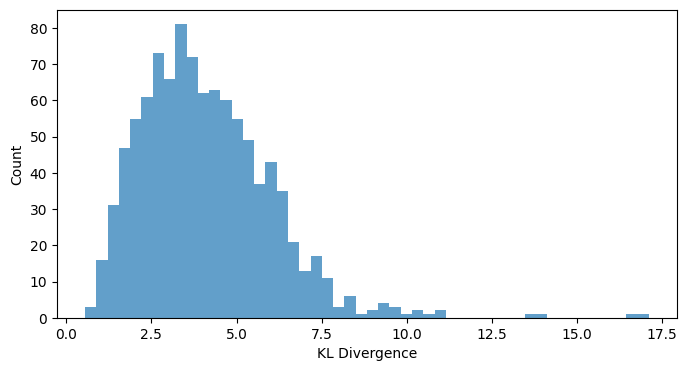

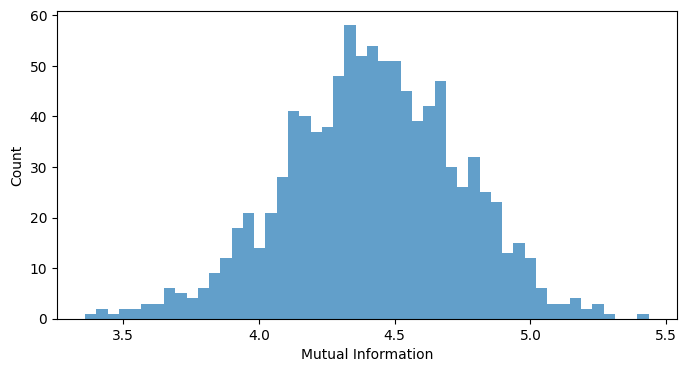

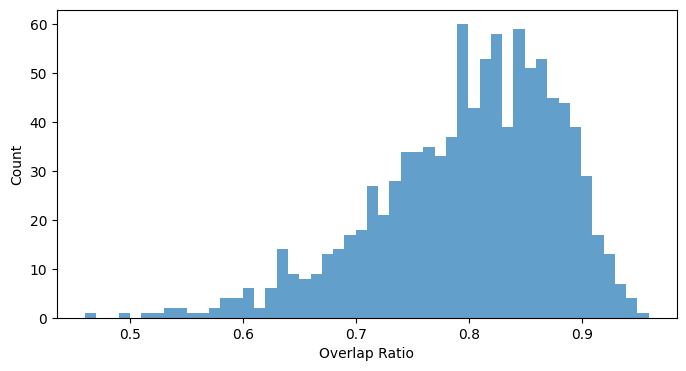

: 

In [ ]:
import random
random.seed(42)
shuffled_indices = list(range(1000))
random.shuffle(shuffled_indices)
res_emd = []
res_kld = []
res_mi = []
res_overlap = []
for i in tqdm(range(1000)):
    mlo_image = shifted_rotated_paired_image[i][0].resize((512, 512))
    cc_image = shifted_rotated_paired_image[shuffled_indices[i]][1].resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=False)
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])
    res_overlap.append(res_dict['overlap'])

print("EMD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_emd), np.std(res_emd), np.min(res_emd), np.max(res_emd)))
print("KLD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_kld), np.std(res_kld), np.min(res_kld), np.max(res_kld)))
print("MI: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_mi), np.std(res_mi), np.min(res_mi), np.max(res_mi)))
print("Overlap: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_overlap), np.std(res_overlap), np.min(res_overlap), np.max(res_overlap)))
plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")
plot_1d_histogram(res_overlap, bins=50, xlabel="Overlap Ratio", ylabel="Count")

100%|██████████| 990/990 [00:04<00:00, 209.00it/s]


EMD: mean 0.12, std 0.07, min 0.02, max 0.41
KLD: mean 2.01, std 2.01, min 0.32, max 21.16
MI: mean 4.34, std 0.45, min 2.43, max 5.47


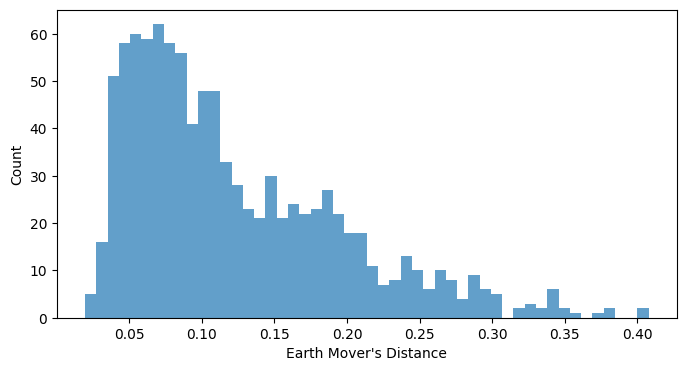

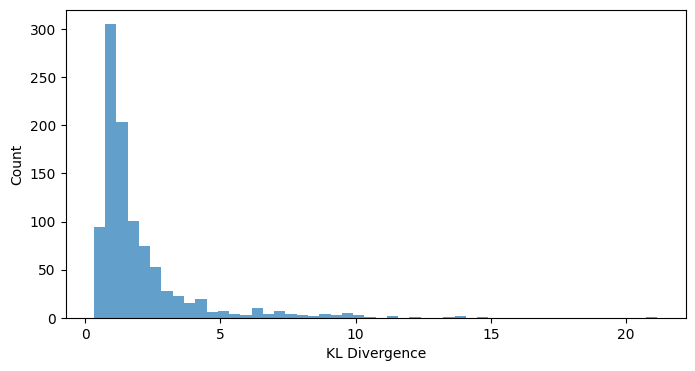

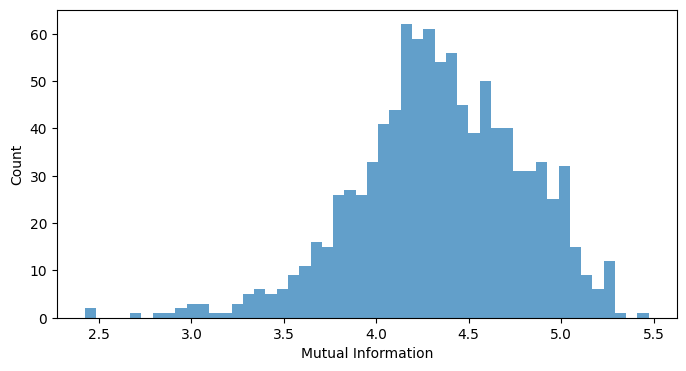

In [36]:
# os.makedirs("tmp/ap_dist/", exist_ok=True)
res_emd = []
res_kld = []
res_mi = []
for i in tqdm(range(len(pair_aligned))):
    mlo_image = pair_aligned[i][0].resize((512, 512))
    cc_image = pair_aligned[i][1].resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=False)
    # res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=f"tmp/ap_dist/pair_{i}.png")
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])

print("EMD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_emd), np.std(res_emd), np.min(res_emd), np.max(res_emd)))
print("KLD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_kld), np.std(res_kld), np.min(res_kld), np.max(res_kld)))
print("MI: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_mi), np.std(res_mi), np.min(res_mi), np.max(res_mi)))
plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")

100%|██████████| 990/990 [03:10<00:00,  5.20it/s]


EMD: mean 0.13, std 0.07, min 0.02, max 0.47
KLD: mean 4.14, std 3.28, min 0.41, max 25.62
MI: mean 4.15, std 0.47, min 1.27, max 5.34


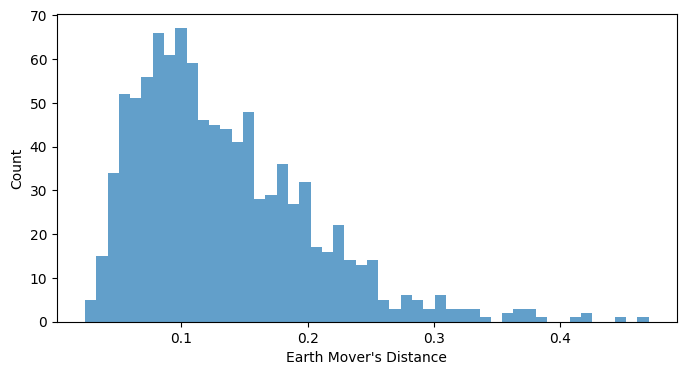

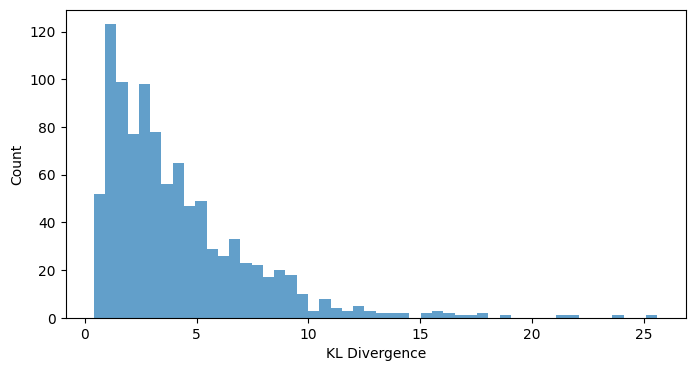

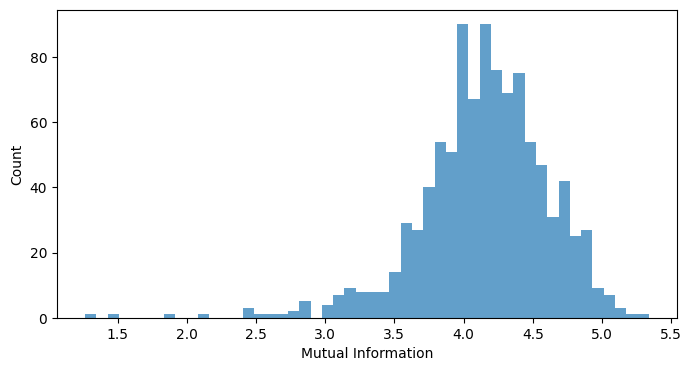

In [37]:
os.makedirs("tmp/ap_dist_affined/", exist_ok=True)
res_emd = []
res_kld = []
res_mi = []
for i in tqdm(range(len(affined_pair))):
    mlo_image = Image.fromarray(affined_pair[i][0]).resize((512, 512))
    cc_image = Image.fromarray(affined_pair[i][1]).resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    # res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=False)
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=f"tmp/ap_dist_affined/pair_{i}.png")
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])

print("EMD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_emd), np.std(res_emd), np.min(res_emd), np.max(res_emd)))
print("KLD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_kld), np.std(res_kld), np.min(res_kld), np.max(res_kld)))
print("MI: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_mi), np.std(res_mi), np.min(res_mi), np.max(res_mi)))
plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")

100%|██████████| 990/990 [02:50<00:00,  5.82it/s]


EMD: mean 0.13, std 0.08, min 0.02, max 0.41
KLD: mean 3.04, std 3.19, min 0.39, max 17.60
MI: mean 4.30, std 0.44, min 2.48, max 5.37


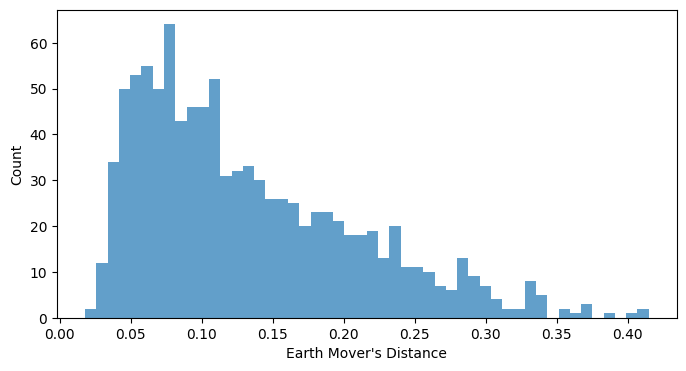

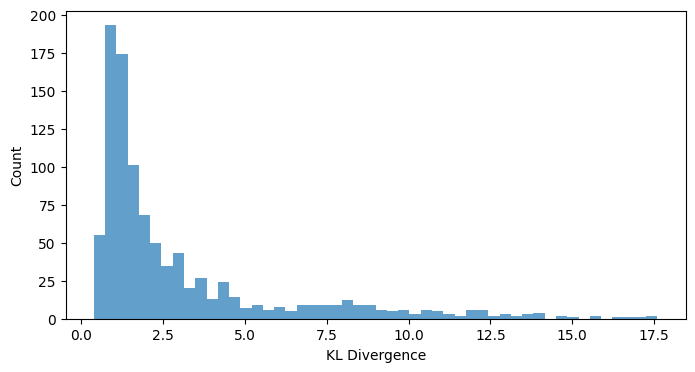

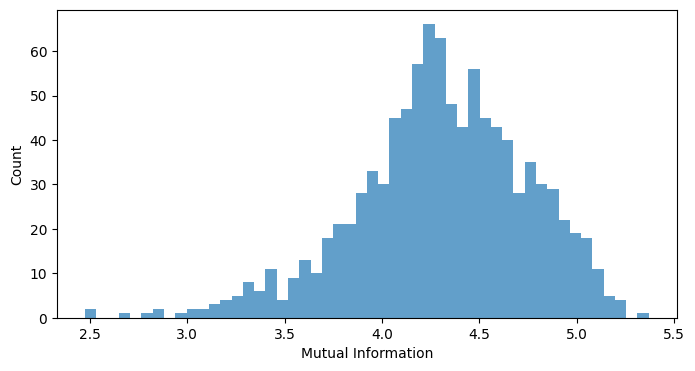

In [41]:
os.makedirs("tmp/ap_dist_sitk/", exist_ok=True)
res_emd = []
res_kld = []
res_mi = []
for i in tqdm(range(len(sitk_registered_pair))):
    mlo_image = Image.fromarray(sitk_registered_pair[i][0]).resize((512, 512))
    cc_image = Image.fromarray(sitk_registered_pair[i][1]).resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    # res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=False)
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=f"tmp/ap_dist_sitk/pair_{i}.png")
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])

print("EMD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_emd), np.std(res_emd), np.min(res_emd), np.max(res_emd)))
print("KLD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_kld), np.std(res_kld), np.min(res_kld), np.max(res_kld)))
print("MI: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_mi), np.std(res_mi), np.min(res_mi), np.max(res_mi)))
plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")

100%|██████████| 990/990 [03:17<00:00,  5.01it/s]


EMD: mean 0.13, std 0.07, min 0.02, max 0.42
KLD: mean 2.52, std 2.37, min 0.35, max 26.28
MI: mean 4.31, std 0.45, min 1.86, max 5.36


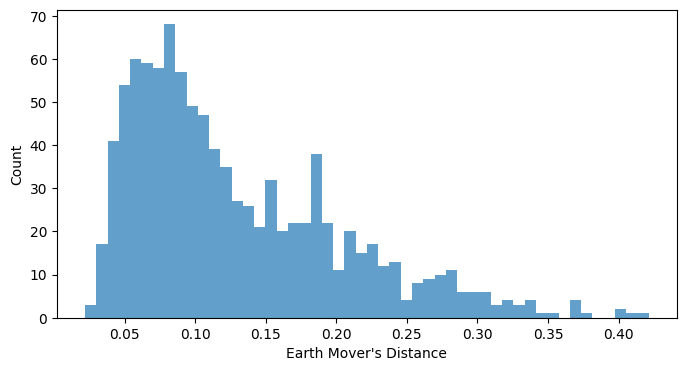

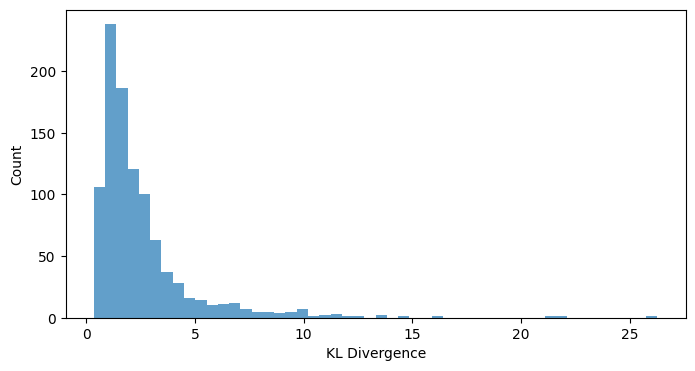

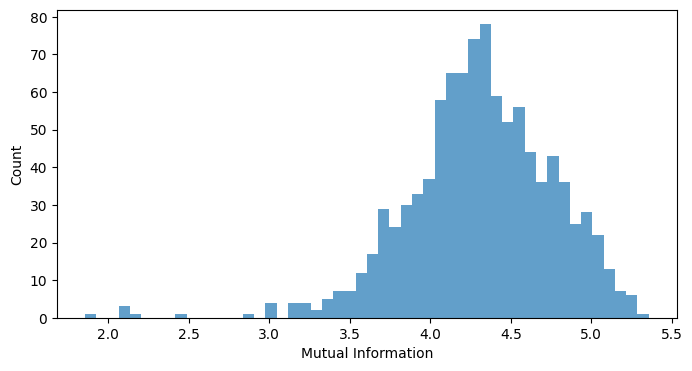

In [42]:
os.makedirs("tmp/ap_dist_motion/", exist_ok=True)
res_emd = []
res_kld = []
res_mi = []
for i in tqdm(range(len(motion_pair))):
    mlo_image = Image.fromarray(motion_pair[i][0]).resize((512, 512))
    cc_image = Image.fromarray(motion_pair[i][1]).resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    # res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=False)
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=f"tmp/ap_dist_motion/pair_{i}.png")
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])

print("EMD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_emd), np.std(res_emd), np.min(res_emd), np.max(res_emd)))
print("KLD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_kld), np.std(res_kld), np.min(res_kld), np.max(res_kld)))
print("MI: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_mi), np.std(res_mi), np.min(res_mi), np.max(res_mi)))
plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")

100%|██████████| 990/990 [03:05<00:00,  5.34it/s]


EMD: mean 0.13, std 0.07, min 0.03, max 0.45
KLD: mean 26.59, std 4.84, min 3.19, max 27.63
MI: mean 4.23, std 0.51, min 1.16, max 5.36


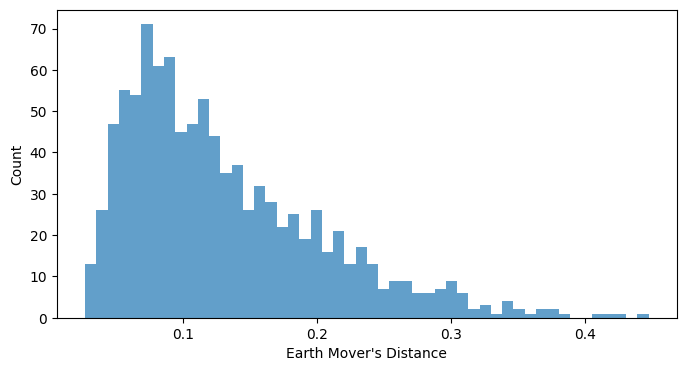

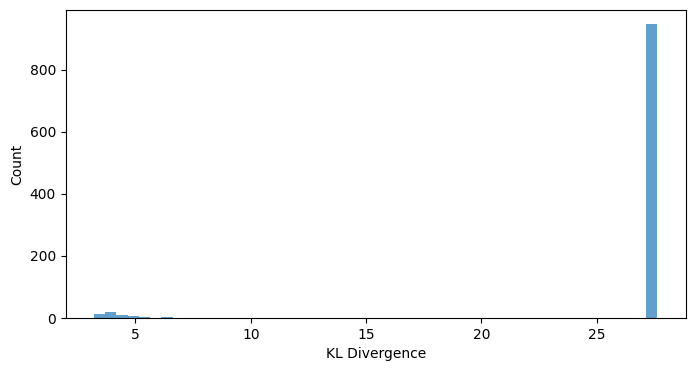

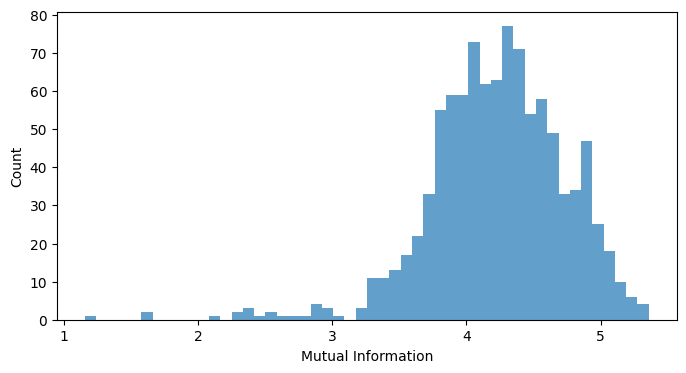

In [43]:
os.makedirs("tmp/ap_dist_phase_correlation/", exist_ok=True)
res_emd = []
res_kld = []
res_mi = []
for i in tqdm(range(len(correlated_image_pairs))):
    mlo_image = Image.fromarray(correlated_image_pairs[i][0]).resize((512, 512))
    cc_image = Image.fromarray(correlated_image_pairs[i][1]).resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    # res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=False)
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=f"tmp/ap_dist_phase_correlation/pair_{i}.png")
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])

print("EMD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_emd), np.std(res_emd), np.min(res_emd), np.max(res_emd)))
print("KLD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_kld), np.std(res_kld), np.min(res_kld), np.max(res_kld)))
print("MI: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_mi), np.std(res_mi), np.min(res_mi), np.max(res_mi)))
plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")

100%|██████████| 1000/1000 [00:04<00:00, 204.45it/s]

EMD: mean 0.15, std 0.08, min 0.02, max 0.47
KLD: mean 2.56, std 2.30, min 0.46, max 21.10
MI: mean 4.30, std 0.39, min 1.69, max 5.37


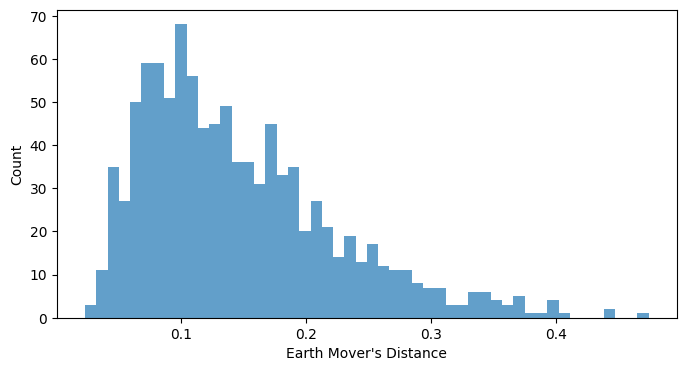

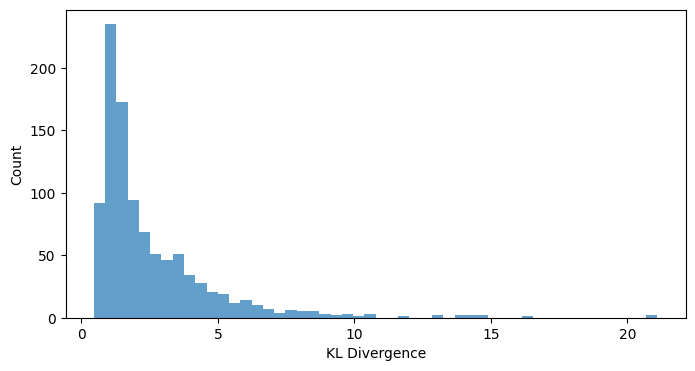

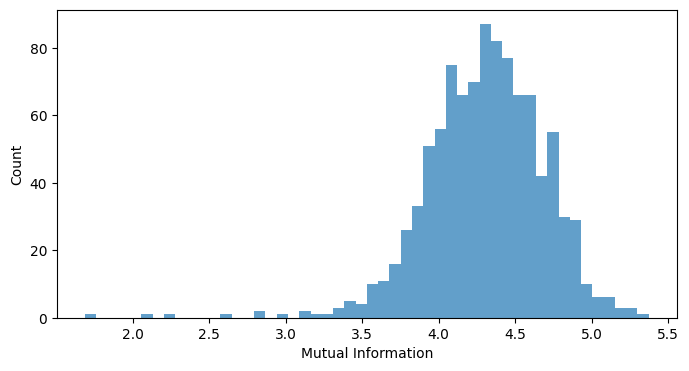

In [87]:
# shuffle the paired images and eval again
import random
random.seed(42)
shuffled_indices = list(range(1000))
random.shuffle(shuffled_indices)
res_emd = []
res_kld = []
res_mi = []
for i in tqdm(range(1000)):
    mlo_image = pair_aligned[i][0].resize((512, 512))
    cc_image = pair_aligned[shuffled_indices[i]][1].resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=False)
    # append res
    res_emd.append(res_dict['emd'])
    res_kld.append(res_dict['kld'])
    res_mi.append(res_dict['mi'])

print("EMD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_emd), np.std(res_emd), np.min(res_emd), np.max(res_emd)))
print("KLD: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_kld), np.std(res_kld), np.min(res_kld), np.max(res_kld)))
print("MI: mean {:.2f}, std {:.2f}, min {:.2f}, max {:.2f}".format(np.mean(res_mi), np.std(res_mi), np.min(res_mi), np.max(res_mi)))
plot_1d_histogram(res_emd, bins=50, xlabel="Earth Mover's Distance", ylabel="Count")
plot_1d_histogram(res_kld, bins=50, xlabel="KL Divergence", ylabel="Count")
plot_1d_histogram(res_mi, bins=50, xlabel="Mutual Information", ylabel="Count")

In [75]:
for i in tqdm(range(5)):
    mlo_image = pair_aligned[i][0].resize((512, 512))
    cc_image = pair_aligned[shuffled_indices[i]][1].resize((512, 512))
    if mlo_image is None or cc_image is None:
        continue
    res_dict = display_distribution_res(mlo_image, cc_image, smooth_sigma=5, save_path=None, show_img=True)

  0%|          | 0/5 [00:00<?, ?it/s]


IndexError: list index out of range

In [28]:
print(np.mean(angle_list), np.median(angle_list))

20.987951807228917 20.000000000000004


In [26]:
print(np.mean(angle_list), np.median(angle_list))

19.801282051282055 20.000000000000004


In [24]:
print(np.mean(angle_list), np.median(angle_list))

19.056603773584907 18.0


In [22]:
print(np.mean(angle_list), np.median(angle_list))

20.635135135135137 20.000000000000004


In [20]:
print(np.mean(angle_list), np.median(angle_list))

19.718562874251496 19.0


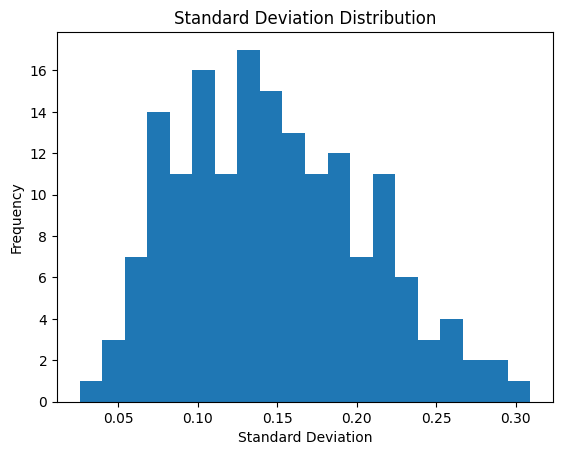

In [19]:
# plot std distribution in a histogram
std_list_arr = np.array(std_list)
plt.hist(std_list_arr[std_list_arr != 100], bins=20)
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.title('Standard Deviation Distribution')
plt.show()